In [8]:
from sklearn.manifold import TSNE
import numpy as np
import json
import csv
import deepdish as dd
import pandas as pd
from tqdm.notebook import tqdm, trange

In [9]:
# file selection widget adapted from: https://gist.github.com/DrDub/6efba6e522302e43d055
import os
import ipywidgets as widgets


class FileBrowser(object):
    def __init__(self, init_dir=None):
        self.path = init_dir if init_dir else os.getcwd()
        self._update_files()
        
    def _update_files(self):
        self.files = list()
        self.dirs = list()
        if(os.path.isdir(self.path)):
            for f in os.listdir(self.path):
                ff = os.path.join(self.path + "/" + f)
                if os.path.isdir(ff):
                    self.dirs.append(f)
                else:
                    self.files.append(f)
        
    def widget(self):
        box = widgets.VBox()
        self._update(box)
        return box
    
    def _update(self, box):
        
        def on_click(b):
            if b.description == '..':
                self.path = os.path.split(self.path)[0]
            else:
                self.path = os.path.join(self.path + "/" + b.description)
            self._update_files()
            self._update(box)
        
        buttons = []
        if self.files:
            button = widgets.Button(description='..', background_color='#d0d0ff')
            button.on_click(on_click)
            buttons.append(button)
        for f in self.dirs:
            button = widgets.Button(description=f, background_color='#d0d0ff')
            button.on_click(on_click)
            buttons.append(button)
        for f in self.files:
            button = widgets.Button(description=f)
            button.on_click(on_click)
            buttons.append(button)
        box.children = tuple([widgets.HTML("<h2>%s</h2>" % (self.path,))] + buttons)

In [10]:
embeddings_path = './embeddings'
f = FileBrowser(embeddings_path)
f.widget()
#   <interact with widget, select a path>

In [11]:
# in a separate cell:
embeddings_file = f.path # returns the selected path
print(embeddings_file)

./embeddings/TENE/tene_dense_embeddings_out.bin


In [12]:
embed_type = embeddings_file.split('/')[-2]
print(embed_type)

embeddings = None
if embed_type in ('BANE', 'TENE'):
    embeddings = {}
    with open(embeddings_file) as embed_file:
        embed_reader = csv.reader(embed_file)
        for i, line in enumerate(embed_reader):
            if i == 0:
                continue
            em_idx, embed = int(float(line[0])), list(map(lambda x: float(x), line[1::]))
            embeddings[em_idx] = embed

else:
    embeddings = dd.io.load(embeddings_file)
    embeddings = np.asarray(embeddings)

with open('./data/services_nodes.json') as sn:
    serv_nodes = json.loads(sn.read())
    
# load our HIN to use the taxonomy code nodes as categories
with open('./data/HIN_nodes.json') as taxo:
    taxo_nodes = json.loads(taxo.read())

with open('./data/code_to_node_num.json') as cn:
    code_trans = json.loads(cn.read())
    
with open('./data/node_num_to_embed_idx.json') as nne:
    node_num_to_embed_idx = json.loads(nne.read())
    
with open('./data/embed_idx_to_node_num.json') as enn:
    embed_idx_to_node_num = json.loads(enn.read())
    
user_attrs_nodes = pd.read_excel('./data/User_Attributes_Nodes.xlsx').to_dict(orient='list')

TENE


# Basic K-means clustering with Cosine Similarity

In [13]:
from nltk.cluster import KMeansClusterer
import nltk

# code adapted from: https://ai.intelligentonlinetools.com/ml/k-means-clustering-example-word2vec/
# don't do k-cluster for BANE since embedding is binary matrix
X = None
if embed_type != 'BANE':
    # Perform kmean clustering
    X = np.array(list(embeddings.values()))
    print(X[:10])
    num_clusters = 10
    kclusterer = KMeansClusterer(num_means=num_clusters, 
                                       distance=nltk.cluster.util.cosine_distance, 
                                      repeats=25)

    assigned_clusters = kclusterer.cluster(X, True)

[[1.00000000e-15 1.00000000e-15 1.00000000e-15 ... 4.40783608e-01
  4.20107626e-01 4.32875647e-01]
 [1.00000000e-15 1.00000000e-15 1.00000000e-15 ... 4.36275287e-13
  1.61555347e-15 1.00000000e-15]
 [1.00000000e-15 1.00000000e-15 8.08794391e-12 ... 3.06389050e-11
  1.00000000e-15 1.00000000e-15]
 ...
 [1.00000000e-15 1.00000000e-15 1.00000000e-15 ... 4.05620282e-01
  3.87750342e-01 3.98299895e-01]
 [1.00000000e-15 1.00000000e-15 1.00000000e-15 ... 4.54492413e-01
  4.27632632e-01 4.49686752e-01]
 [1.00000000e-15 1.00000000e-15 1.00000000e-15 ... 1.00000000e-15
  1.07674044e-10 1.00000000e-15]]


In [16]:
# map broadest taxonomy codes to different scatter plot markers
markers = [',', '^', '2', 's', 'p', 'P', '*', 'X', 'D', 'v', '_', 'h',]
codes = set()
code_to_marker = {}
marker_to_code = {}
code_to_name = {}
embed_idx_to_code = {}
serv_embed_markers = []
serv_embed_codes = []
for i in range(len(embeddings)):
    node_num = embed_idx_to_node_num[str(i)]
    # only consider the first code as main category
    # pick the first letter to select the broadest code category
    serv_codes = taxo_nodes[node_num]['codes']
    if not serv_codes:
#         print("{} service has no codes".format(taxo_nodes[node_num]['name']))
        broad_serv_code = 'X'
        code_to_name[broad_serv_code] = 'No Code Present'
    else:
        broad_serv_code = serv_codes[0][0]
        code_to_name[broad_serv_code] = taxo_nodes[str(code_trans[broad_serv_code])]['name']
    codes.add(broad_serv_code)
    embed_idx_to_code[i] = broad_serv_code

code_names = [] 
code_idxs = {}
for i, c in enumerate(codes):
    code_names.append("{}: {}".format(c, code_to_name[c]))
    code_idxs[c] = i
    
# for i in range(len(embeddings)):
    
print("Using broadest codes:\n\n{}".format('\n'.join(code_names)))
for i, code in enumerate(sorted(codes)):
    code_to_marker[code] = markers[i]
    marker_to_code[markers[i]] = code_to_name[code]
#     print("{} -> {}".format(code, markers[i]))
    
for i in range(len(embeddings)):
    serv_embed_markers.append(code_to_marker[embed_idx_to_code[i]])

Using broadest codes:

F: Criminal Justice and Legal Services
H: Education
L: Health Care
R: Mental Health and Substance Use Disorder Services
Y: Target Populations
X: No Code Present
N: Income Support and Employment
B: Basic Needs
P: Individual and Family Life
D: Consumer Services
J: Environment and Public Health/Safety
T: Organizational/Community/International Services


# Visualize k-means clusters

In [21]:
import matplotlib.pyplot as plt
import matplotlib.markers as mmark
import matplotlib.cm as cm
from sklearn.manifold import TSNE
 
# remove later
X = np.array(list(embeddings.values()))

# def get_cmap(n, name='cool'):
#     # Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#     # RGB color; the keyword argument name must be a standard mpl colormap name.
#     return plt.cm.get_cmap(name, n)

# cmap = get_cmap(num_clusters)

model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
 
Y=model.fit_transform(X)
xs, ys = Y[:, 0], Y[:, 1] 

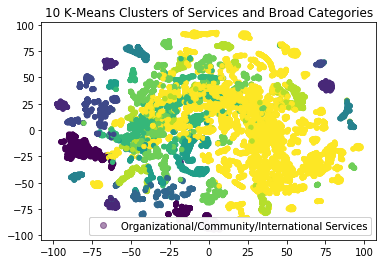

In [36]:
# for x,y,c,m in zip(xs, ys, assigned_clusters, serv_embed_markers):
#       plt.scatter([x], [y], c=cmap(c), marker=m, s=290, alpha=.5)
fig, ax = plt.subplots(figsize=(15,15))
# colors = cm.rainbow(np.linspace(0, 1, len(codes)))
scatter = ax.scatter(x=Y[:, 0], y=Y[:, 1], c=assigned_clusters, s=20)

# leg_marks = [c for c in colors]
# leg_lbls = [marker_to_code[m] for m in markers]

handles, _ = scatter.legend_elements(prop='colors', alpha=0.4)
labels = [code_to_name[c]]

legend = ax.legend(handles, labels, loc='lower right')
ax.add_artist(legend)
ax.set_title("{} K-Means Clusters of Services and Broad Categories".format(num_clusters))
fig.savefig("./figures/service_codes_{}_embeddings_t-SNE_K-means_clusters.png".format(embed_type), dpi=300)
# for j in range(len(sentences)):    
#    plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
#    print ("%s %s" % (assigned_clusters[j],  sentences[j]))
 
 
plt.show()

In [37]:
import matplotlib.pyplot as plt
import matplotlib.markers as mmark
import matplotlib.cm as cm
from sklearn.manifold import TSNE
 
# remove later
X = np.array(list(embeddings.values()))

# def get_cmap(n, name='cool'):
#     # Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
#     # RGB color; the keyword argument name must be a standard mpl colormap name.
#     return plt.cm.get_cmap(name, n)

# cmap = get_cmap(num_clusters)

model = TSNE(n_components=3, random_state=0)
np.set_printoptions(suppress=True)
 
Y_3d=model.fit_transform(X)
xs_3d, ys_3d = Y[:, 0], Y[:, 1] 

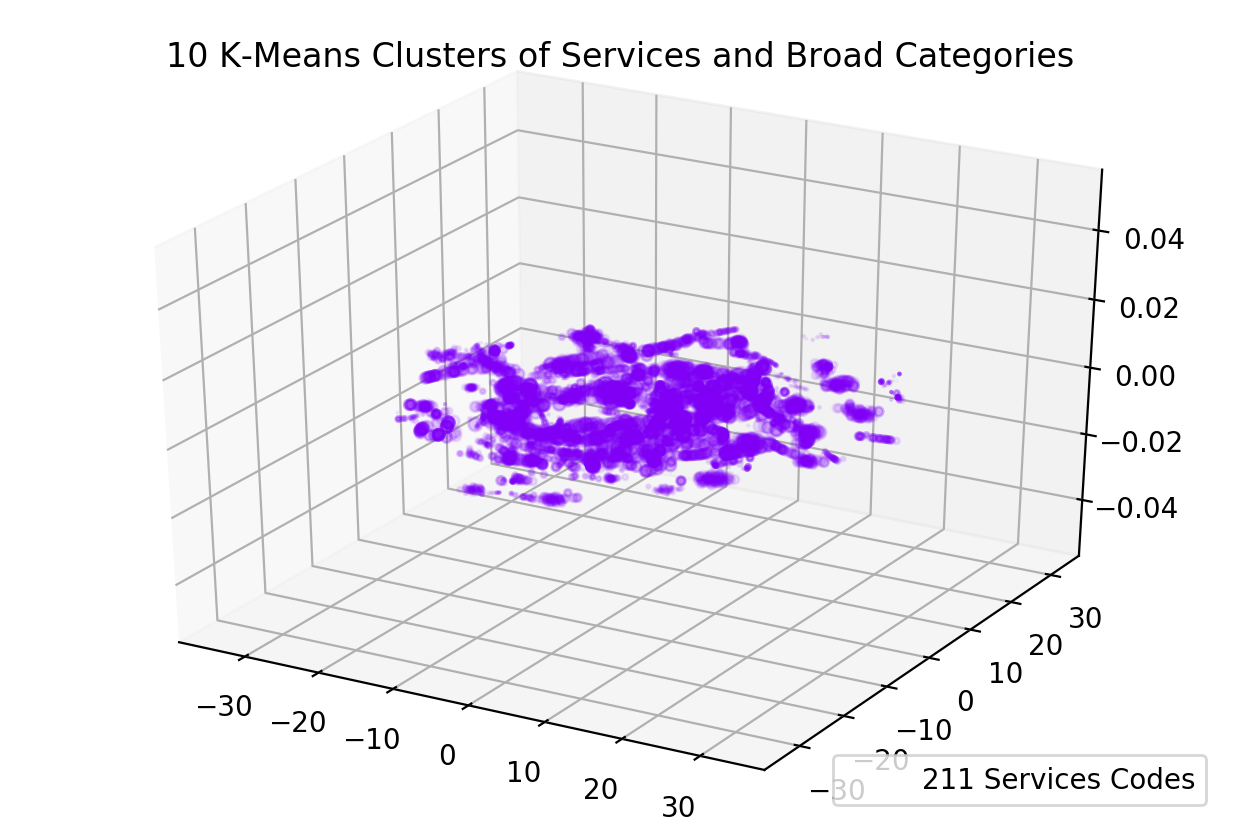

In [54]:
def tsne_plot_3d(title, label, embeds, a=1, fname=None):
    fig = plt.figure(dpi=200)
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(embeds[:, 0], embeds[:, 1], embeds[:, 2], c=colors, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.savefig(fname)
    plt.show()

embed_3d_title = "{} K-Means Clusters of Services and Broad Categories".format(num_clusters)
embed_3d_fname = "./figures/service_codes_{}_embeddings_t-SNE_K-means_clusters.png".format(embed_type)
tsne_plot_3d(embed_3d_title, '211 Services Codes', Y_3d, a=0.1, fname=embed_3d_fname)

# # for x,y,c,m in zip(xs, ys, assigned_clusters, serv_embed_markers):
# #       plt.scatter([x], [y], c=cmap(c), marker=m, s=290, alpha=.5)
# fig, ax = plt.subplots()
# # colors = cm.rainbow(np.linspace(0, 1, len(codes)))
# scatter = ax.scatter(Y_3d[:, 0], Y_3d[:, 1], Y_3d[:, 2], c=assigned_clusters, s=20)

# # leg_marks = [c for c in colors]
# # leg_lbls = [marker_to_code[m] for m in markers]

# handles, _ = scatter.legend_elements(prop='colors', alpha=0.4)
# labels = [code_to_name[c]]

# legend = ax.legend(handles, labels, loc='lower right')
# ax.add_artist(legend)
# ax.set_title("{} K-Means Clusters of Services and Broad Categories".format(num_clusters))
# fig.savefig("./figures/service_codes_{}_embeddings_t-SNE_K-means_clusters.png".format(embed_type), dpi=300)
# # for j in range(len(sentences)):    
# #    plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
# #    print ("%s %s" % (assigned_clusters[j],  sentences[j]))
 
 
# plt.show()

In [26]:
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cdist

# see this section for more info: https://github.com/UKPLab/sentence-transformers#pretrained-models
models = [
    'roberta-base-nli-stsb-mean-tokens'
]
choice = '-1'
choice_list = '\n'.join(["{}. {}".format(i+1, models[i]) for i in range(len(models))])
while int(choice)-1 nabsot in list(range(len(models))) or not choice.isdigit():
    choice = input("Choose one of the following pre-trained models to use: \n{}".format(choice_list))
choice = int(choice)-1

model = SentenceTransformer(models[choice])

def getK_Similar(sentences, model, top_k=20):
    sent_embed = model.encode(sentences)
#     print(sent_embed)
    # get cosine distance to all embeddings
    distances = cdist(sent_embed, embeddings, "cosine")[0]

    # zip a tuple of (nserv_nodes dist)
    results = zip(list(serv_nodes.keys()), distances)
    # sort the tuples according to distance
    results = sorted(results, key=lambda x: x[1])
    

    return results[:top_k]

Choose one of the following pre-trained models to use: 
1. roberta-base-nli-stsb-mean-tokens 1


In [60]:
# plotting code from here: https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d
# some background: https://medium.com/cindicator/t-sne-and-word-embedding-weekend-of-a-data-scientist-5c99ddacbf51

node_num_to_embed_idx = {}
for i, nn in enumerate(serv_nodes):
    node_num_to_embed_idx[nn] = i

top_k = 200

# try to cluster according to user attributes from poverty study
user_attr_cats = {}
for i in range(0,len(user_attrs_nodes['id'])):
    
    category = user_attrs_nodes['Category'][i]
    if category == 'User':
        continue
    label = user_attrs_nodes['Label'][i]
    description = user_attrs_nodes['Description'][i]
    if description in ('General Background', 'Abilities', 'Documents'):
        continue
    
    # save all items related to a description
    if description in user_attr_cats:
        user_attr_cats[description] = user_attr_cats[description] + [label]
    else:
        user_attr_cats[description] = [label]
    

embedding_clusters = []
word_clusters = []
for cat in user_attr_cats:
    sent = [cat] + user_attr_cats[cat]
    embeds = []
    servs = []
    dists = []
    similar_servs = getK_Similar(sent, model, top_k=50)
    for node_num, dist in similar_servs:
        sim_serv = serv_nodes[node_num]['name']
        servs.append(sim_serv)
        embed = embeddings[node_num_to_embed_idx[node_num]]
        embeds.append(embed)
        dists.append(dist)
    embedding_clusters.append(embeds)
    avg_dist = sum(dists) / len(dists)
    print("{} category had an average similarity of {} for {} services".format(cat, 1-avg_dist, top_k))
    # avoid duplicate labels 
    uniq_servs = set()
    for i, serv in enumerate(servs):
        # eliminate services that are the same but with diff subtitles
#         serv = serv.split('-')[0].strip()
        if serv in uniq_servs:
            servs[i] = ''
        else:
            uniq_servs.add(serv)
    word_clusters.append(servs)

Employment category had an average similarity of 0.7454361149694335 for 200 services
Transportation category had an average similarity of 0.7656624068484589 for 200 services
Criminal Background category had an average similarity of 0.519262365263538 for 200 services
Food Access category had an average similarity of 0.8445592811949632 for 200 services
Education category had an average similarity of 0.7331237154473391 for 200 services
Health category had an average similarity of 0.6560098496212051 for 200 services
Housing category had an average similarity of 0.6845634141031004 for 200 services
Financial Wellness category had an average similarity of 0.5661464194319024 for 200 services
Well-Being category had an average similarity of 0.5869193715464271 for 200 services


In [61]:
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

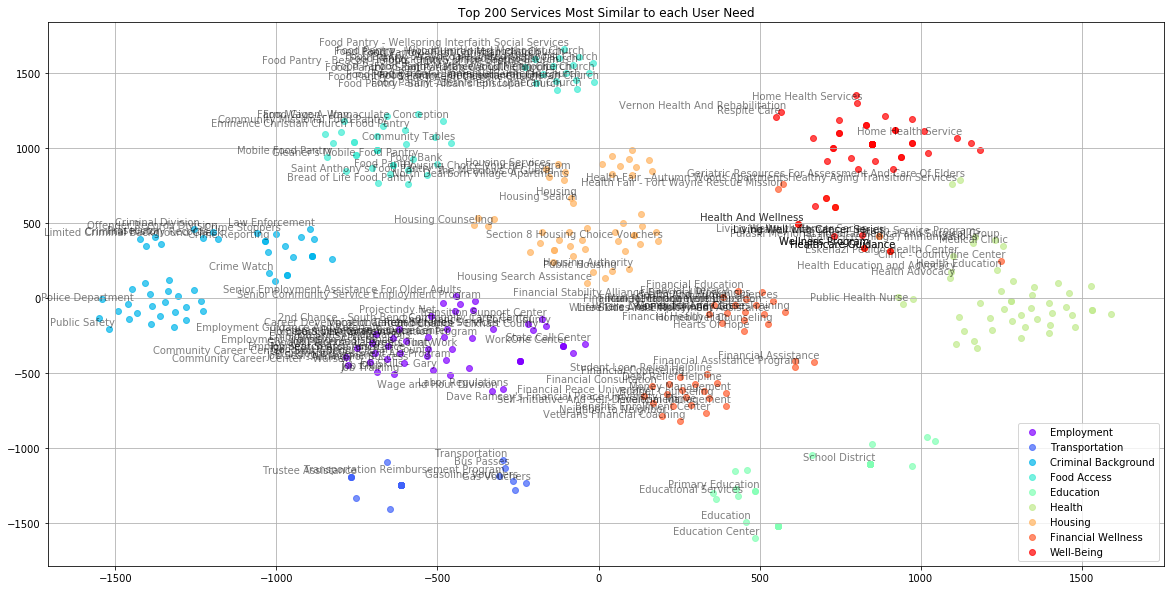

In [63]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(20, 10))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    with tqdm(total=len(word_clusters), desc='Plotting Cluster') as pbar1:
        for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
            x = embeddings_en_2d[:, 0]
            y = embeddings_en_2d[:, 1]
            plt.scatter(x, y, c=color, alpha=a, label=label)
            for i, word in enumerate(words):
                plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                             textcoords='offset points', ha='right', va='bottom', size=10)
            pbar1.update()
            
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    plt.show()

tsne_fig_path = './figures/top-{}-services-user-needs'.format(top_k)
tsne_plot_similar_words('Top {} Services Most Similar to each User Need'.format(top_k), list(user_attr_cats.keys()), embeddings_en_2d, word_clusters, 0.7, filename=tsne_fig_path)

NameError: name 'words' is not defined

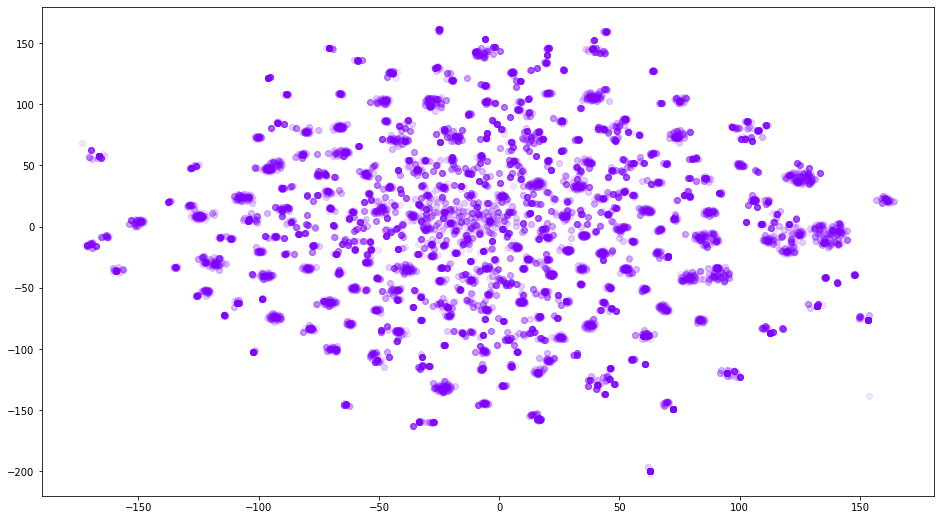

In [8]:

servs = []
embeds = []
for node_num in serv_nodes:
    embeds.append(embeddings[node_num_to_embed_idx[node_num]])
    servs.append(serv_nodes[node_num]['name'])
    
tsne_2d = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3500, random_state=32)
embeds_2d = tsne_2d.fit_transform(embeds)

def tsne_plot_2d(label, embeds, servs=[], a=1):
    
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeds[:,0]
    y = embeds[:,1]
    plt.scatter(x, y, c=colors, alpha=a, label=label)
    with tqdm(total=len(servs), desc='Plotting data points') as pbar2:
        for i, serv in enumerate(servs):
            plt.annotate(serv, alpha=0.3, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=10)
        pbar2.update(1)
    plt.legend(loc=4)
    plt.grid(True)
    plt.savefig("hhh.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()

tsne_plot_2d('All Services Clustered by User Needs', embeds_2d, a=0.1)

In [38]:
from mpl_toolkits.mplot3d import Axes3D

tsne_3d = TSNE(perplexity=40, n_components=3, init='pca', n_iter=3500, random_state=32)
embeds_3d = tsne_3d.fit_transform(embeds)


def tsne_plot_3d(title, label, embeds, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(embeds_3d[:, 0], embeds_3d[:, 1], embeds[:, 2], c=colors, alpha=a, label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.show()


tsne_plot_3d('3D TSNE Visualization for Sentence-BERT Embeddings', '211 Services', embeds_3d, a=0.1)

NameError: name 'embeds' is not defined